Let's plot some simple linear data of the form

`y = WX +b`

Where W and X have D dimensions (likely start with two).


### Data Setup

Take from Edward.

http://edwardlib.org/tutorials/supervised-regression



In [1]:
import numpy as np

In [2]:
'''
N = number of samples
W = vector of weight values. 
'''
def build_toy_dataset(N, D, w, noise_std=0.1):
  D = len(w)
  x = np.random.randn(N, D)
  y = np.dot(x, w) + np.random.normal(0, noise_std, size=N)
  return x, y



In [4]:
N = 40  # number of data points
D = 10  # number of features

w_true = np.random.randn(D) # the true weight vectors.
X_train, y_train = build_toy_dataset(N, D, w_true)
X_test, y_test = build_toy_dataset(N, D, w_true)

In [5]:
print(X_train.shape, y_train.shape)

(40, 10) (40,)


### pymc3

Assume you have a linear model as follows:

\begin{split}\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}\end{split}

However, let's assume that

* Beta is W
* There are D, Beta model parameters. 

Let's make the following assumptions about our parameter's prior distributions.

\begin{split}\begin{aligned}
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}\end{split}

In [6]:
import pymc3 as pm
from theano import tensor
from pymc3 import Normal, HalfNormal
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
with pm.Model() as m:
    alpha = pm.Normal('alpha', mu=0, sd=10) #intercept
    beta  = pm.Normal('beta', mu=0, sd=10, shape=D)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    mu = alpha + tensor.dot(X_train, beta) #note: real training data added here
    yl = pm.Normal('y_est', mu=mu, sd=sigma, observed=y_train) 

In [8]:
#find the MAP
with m:
    map_estimate = pm.find_MAP()


Optimization terminated successfully.
         Current function value: -7.710500
         Iterations: 46
         Function evaluations: 60
         Gradient evaluations: 60


In [9]:
map_estimate

{'alpha': array(-0.024241630187274873),
 'beta': array([-1.36082332,  0.58869867, -1.06996688,  1.27441121, -0.38959144,
         0.57942745, -0.97689533, -0.75853304,  1.20064571, -0.64616727]),
 'sigma_log_': array(-2.555918943081185)}

In [30]:
#sample from the approximate posterior

In [10]:
#pymc3 should automatically assign NUTS
with m:
    trace = pm.sample(draws=1000, start=map_estimate)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -31.03: 100%|██████████| 200000/200000 [00:21<00:00, 9141.79it/s] 
Finished [100%]: Average ELBO = -31.063
100%|██████████| 1000/1000 [00:04<00:00, 247.65it/s]


In [43]:
trace.varnames

['alpha', 'beta', 'sigma_log_', 'sigma']

In [44]:
trace.beta[0][:10]

array([ 1.00905134,  1.64375007,  0.44750415, -0.75216908,  1.02740198,
        3.26570532,  0.01617079, -0.51930227,  0.24593638,  0.67175506])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122b05ef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x122b88550>]], dtype=object)

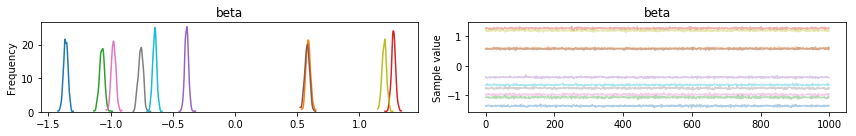

In [11]:
pm.plots.traceplot(trace=trace, varnames=["beta"])

### Edward - Take 1

Let's try to create the same model shown above for this one.  We can make it look more like the edward example if we fail. 

In [58]:
from edward.models import Normal
import tensorflow as tf
import edward as ed
from tensorflow import random_normal, Variable

X     = tf.placeholder(tf.float32, [N, D]) #placeholder for feed_dict
beta  = Normal(loc=tf.zeros(D), scale=tf.ones(D)*10) #loc = mu, scale = sd
alpha = Normal(loc=tf.zeros(1), scale=tf.ones(1)*10)
sigma = Normal(loc=tf.zeros(1), scale=tf.ones(1)) 
mu    = ed.dot(X, beta) + alpha

#y     = Normal(loc=mu, scale=tf.ones(N))  
y     = Normal(loc=mu, scale=tf.abs(sigma)) #used tf.abs to create half normal.  This is likely not correct. 


#variables for variational inference
q_beta  = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))  #note use of tf.variable here.  Not tf.ones
q_alpha = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1])))) #softplus like smooth relu. Always positive.

#NOTE: do I need a q_sigma?
q_sigma = Normal(loc=Variable(random_normal([1])),
           scale=tf.nn.softplus(Variable(random_normal([1]))))

#need q variables for all stochastic priors (not deterministic)

In [59]:
#run inference
inference = ed.KLqp({beta: q_beta, alpha: q_alpha, sigma: q_sigma}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)


250/250 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 1222.608
